<a href="https://colab.research.google.com/github/lb-97/GenerativeAIMNIST/blob/main/VQVAE-MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q tensorflow-probability

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow as tf

In [ ]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        # The `beta` parameter is best kept between [0.25, 2] as per the paper.
        self.beta = beta

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)

        # Reshape the quantized values back to the original input shape
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(self.beta * commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs, distribution=False):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )
        if distribution:
          return distances
        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices


In [ ]:
def get_encoder(latent_dim=16, shape=(28, 28, 1)):
    encoder_inputs = keras.Input(shape=shape)
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(
        encoder_inputs
    )
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    encoder_outputs = layers.Conv2D(latent_dim, 1, padding="same")(x)
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")


def get_decoder(latent_dim=16, shape=(28, 28, 1)):
    latent_inputs = keras.Input(shape=get_encoder(latent_dim, shape=shape).output.shape[1:])
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(
        latent_inputs
    )
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(shape[-1], 3, padding="same")(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")


In [ ]:
get_encoder().summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 14, 14, 32)        320       
                                                                 
 conv2d_16 (Conv2D)          (None, 7, 7, 64)          18496     
                                                                 
 conv2d_17 (Conv2D)          (None, 7, 7, 16)          1040      
                                                                 
Total params: 19,856
Trainable params: 19,856
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def get_encoder(latent_dim=16, shape=(128,128,128,1)):
    encoder_inputs = keras.Input(shape=shape)
    x = layers.Conv3D(32, 3, activation="relu", strides=2, padding="same")(
        encoder_inputs
    )
    x = layers.Conv3D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv3D(128, 3, activation="relu", strides=2, padding="same")(x)
    encoder_outputs = layers.Conv3D(latent_dim, 1, padding="same")(x) #(16,16,16,latent_dim)
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")


def get_decoder(latent_dim=16, shape=(128,128,128,1)):
    latent_inputs = keras.Input(shape=get_encoder(latent_dim, shape=shape).output.shape[1:])
    x = layers.Conv3DTranspose(128, 3, activation="relu", strides=2, padding="same")(
        latent_inputs
    )
    x = layers.Conv3DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv3DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv3DTranspose(shape[-1], 3, padding="same")(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")

get_decoder().summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 16, 16, 16, 16)]  0         
                                                                 
 conv3d_transpose_8 (Conv3DT  (None, 32, 32, 32, 128)  55424     
 ranspose)                                                       
                                                                 
 conv3d_transpose_9 (Conv3DT  (None, 64, 64, 64, 64)   221248    
 ranspose)                                                       
                                                                 
 conv3d_transpose_10 (Conv3D  (None, 128, 128, 128, 32  55328    
 Transpose)                  )                                   
                                                                 
 conv3d_transpose_11 (Conv3D  (None, 128, 128, 128, 1)  865      
 Transpose)                                                

In [ ]:
def get_vqvae(latent_dim=16, num_embeddings=64,shape=(28,28,1)):
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    encoder = get_encoder(latent_dim, shape=shape)
    decoder = get_decoder(latent_dim, shape=shape)
    inputs = keras.Input(shape=shape)
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return keras.Model(inputs, reconstructions, name="vq_vae")


get_vqvae().summary()

Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 7, 7, 16)          19856     
                                                                 
 vector_quantizer (VectorQua  (None, 7, 7, 16)         1024      
 ntizer)                                                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         28033     
                                                                 
Total params: 48,913
Trainable params: 48,913
Non-trainable params: 0
_________________________________________________________________


In [ ]:
class VQVAETrainer(keras.models.Model):
    def __init__(self, train_variance, latent_dim=32, num_embeddings=128, shape=(28, 28, 1),**kwargs):
        super().__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings, shape)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
            )
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }


In [ ]:
(x_train, x_train_labels), (x_test, _) = keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_train_scaled = (x_train / 255.0) -0.5
x_test_scaled = (x_test / 255.0) - 0.5
#print(x_train_scaled.max(), x_train_scaled.min())

data_preprocessing = tf.keras.Sequential(
    layers.Resizing(32,32)
)
x_train_scaled = data_preprocessing(x_train_scaled)
#print(tf.math.reduce_max(x_train_scaled), tf.math.reduce_max(x_train_scaled))

data_variance = np.var(x_train_scaled)
data_variance

0.5 -0.5


0.083655156

In [ ]:
# (x_train, _), (x_test, _) = keras.datasets.cifar10.load_data()
# x_train = np.expand_dims(x_train, -1)
# x_test = np.expand_dims(x_test, -1)
# x_train_scaled = (x_train / 255.0) - 0.5
# x_test_scaled = (x_test / 255.0) - 0.5

# data_variance = np.var(x_train / 255.0)

## Train the VQ-VAE model

In [ ]:
vqvae_trainer = VQVAETrainer(data_variance, latent_dim=16, num_embeddings=128,shape=(32,32,1))
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
vqvae_trainer.fit(x_train_scaled, epochs=30, batch_size=128)

Epoch 1/30
469/469 [==============================] - 7s 9ms/step - loss: 2.6129 - reconstruction_loss: 0.3105 - vqvae_loss: 1.9304
Epoch 2/30
469/469 [==============================] - 4s 9ms/step - loss: 1.3404 - reconstruction_loss: 0.1011 - vqvae_loss: 1.2303
Epoch 3/30
469/469 [==============================] - 4s 8ms/step - loss: 0.4469 - reconstruction_loss: 0.0736 - vqvae_loss: 0.3690
Epoch 4/30
469/469 [==============================] - 4s 8ms/step - loss: 0.2688 - reconstruction_loss: 0.0574 - vqvae_loss: 0.2080
Epoch 5/30
469/469 [==============================] - 4s 9ms/step - loss: 0.2045 - reconstruction_loss: 0.0475 - vqvae_loss: 0.1552
Epoch 6/30
469/469 [==============================] - 4s 8ms/step - loss: 0.1687 - reconstruction_loss: 0.0417 - vqvae_loss: 0.1258
Epoch 7/30
469/469 [==============================] - 4s 8ms/step - loss: 0.1534 - reconstruction_loss: 0.0380 - vqvae_loss: 0.1146
Epoch 8/30
469/469 [==============================] - 4s 9ms/step - loss: 0.

In [ ]:
vqvae_trainer.save_weights('./vqvae-weights.ckpt')

In [ ]:
vqvae_trainer2 = VQVAETrainer(data_variance, latent_dim=16, num_embeddings=128,shape=(32,32,1))
# vqvae_trainer2.load_weights('./vqvae-weights.ckpt')
vqvae_trainer2.vqvae.summary()

Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 32, 32, 1)]       0         
                                                                 
 encoder (Functional)        (None, 8, 8, 16)          19856     
                                                                 
 vector_quantizer (VectorQua  (None, 8, 8, 16)         2048      
 ntizer)                                                         
                                                                 
 decoder (Functional)        (None, 32, 32, 1)         28033     
                                                                 
Total params: 49,937
Trainable params: 49,937
Non-trainable params: 0
_________________________________________________________________


## Reconstruction results on the test set

1/1 [==============================] - 0s 283ms/step


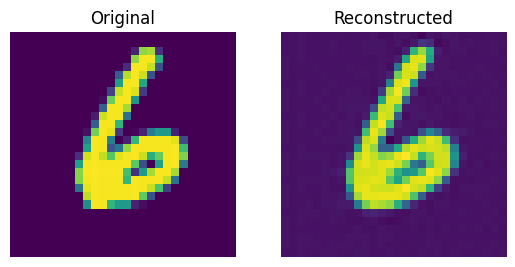

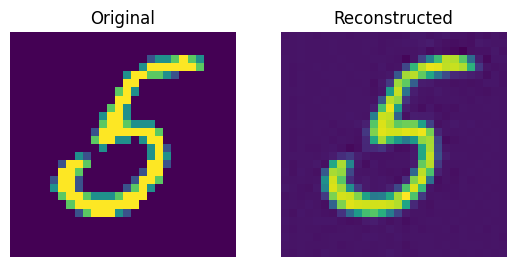

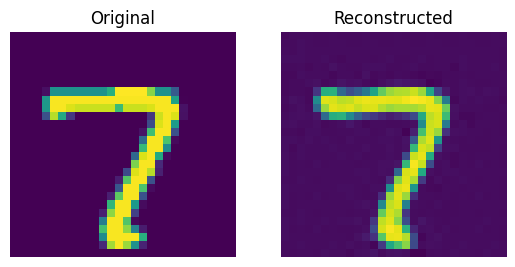

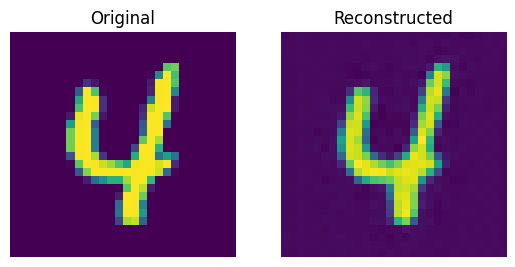

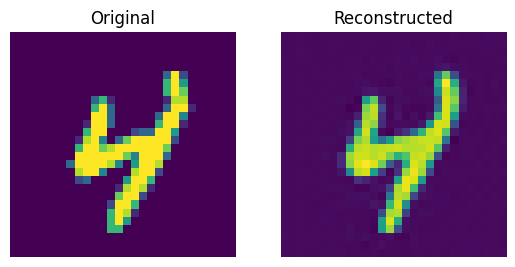

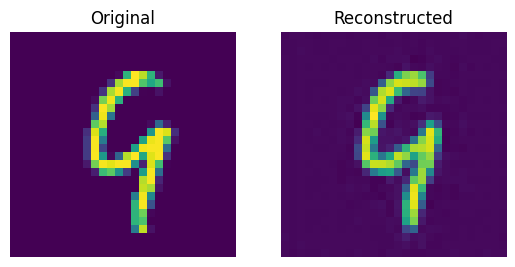

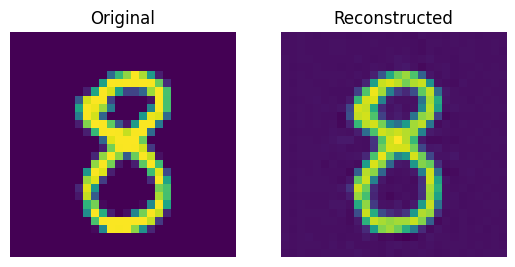

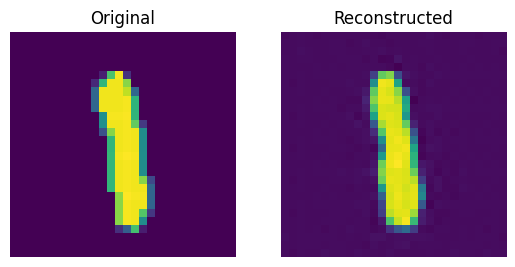

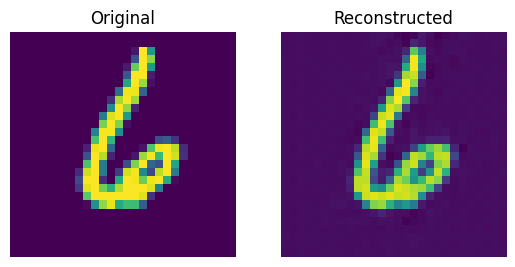

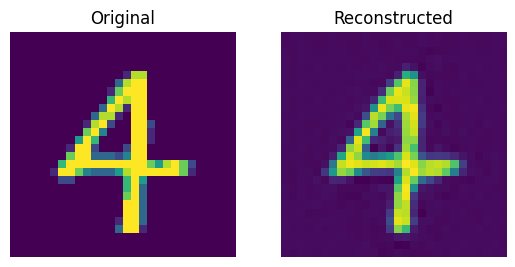

In [ ]:

def show_subplot(original, reconstructed):
    plt.subplot(1, 2, 1)
    plt.imshow(original.squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.squeeze() + 0.5)
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()

# vqvae_trainer.load_weights('./vqvae-weights.ckpt')
trained_vqvae_model = vqvae_trainer.vqvae
idx = np.random.choice(len(x_test_scaled), 10)
test_images = x_test_scaled[idx]
reconstructions_test = trained_vqvae_model.predict(test_images)

for test_image, reconstructed_image in zip(test_images, reconstructions_test):
    show_subplot(test_image, reconstructed_image)

## Visualizing the discrete codes

1/1 [==============================] - 0s 48ms/step


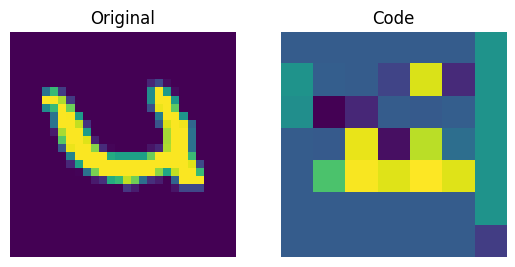

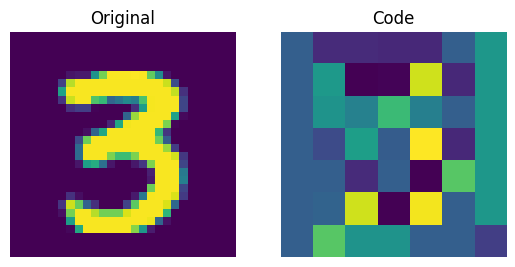

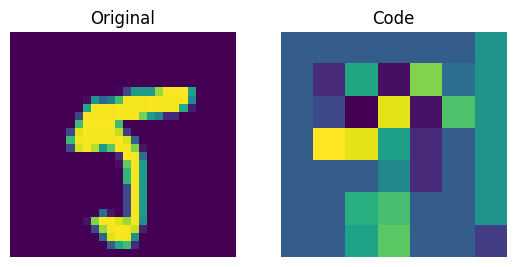

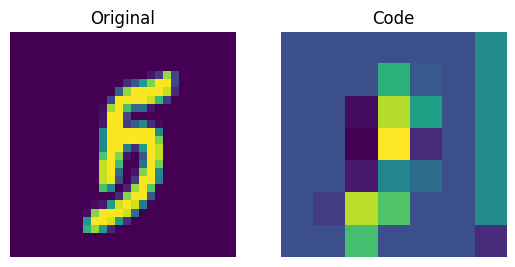

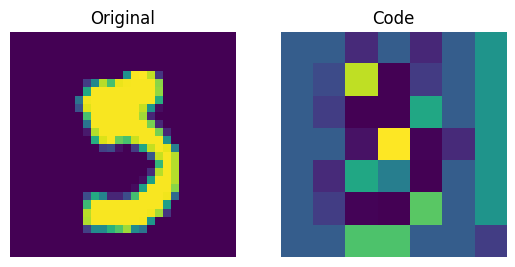

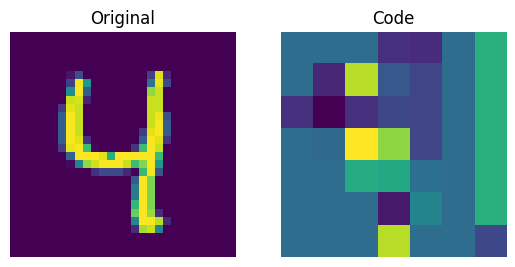

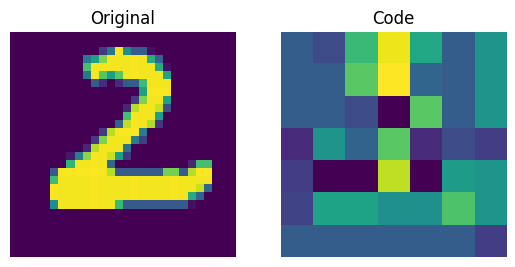

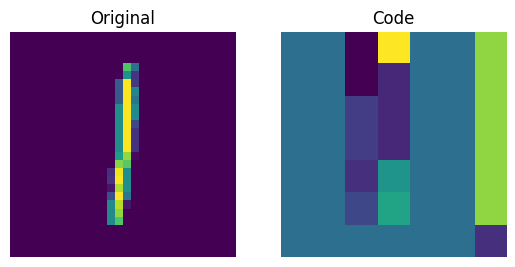

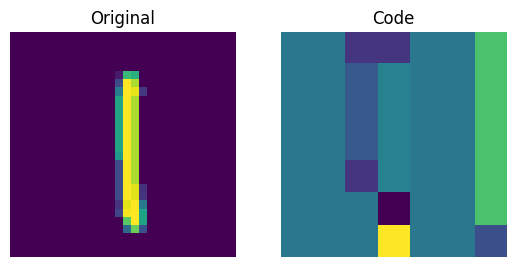

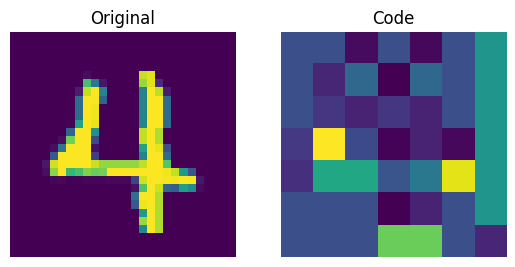

In [ ]:
encoder = vqvae_trainer.vqvae.get_layer("encoder")
quantizer = vqvae_trainer.vqvae.get_layer("vector_quantizer")

encoded_outputs = encoder.predict(test_images)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

for i in range(len(test_images)):
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i].squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(codebook_indices[i])
    plt.title("Code")
    plt.axis("off")
    plt.show()

1/1 [==============================] - 0s 76ms/step


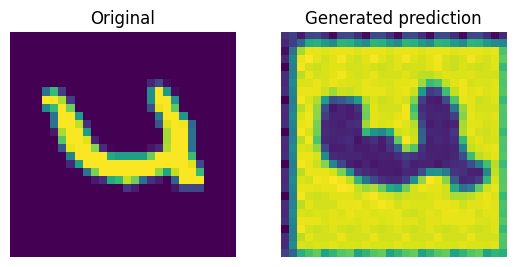

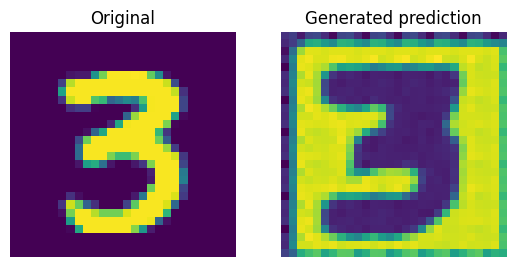

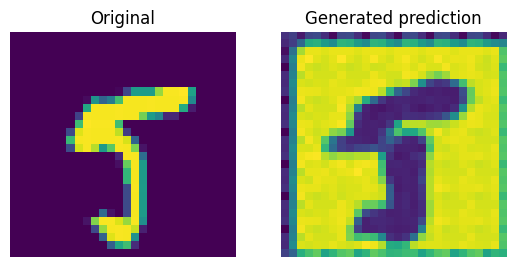

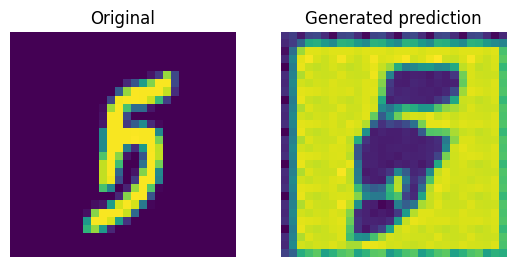

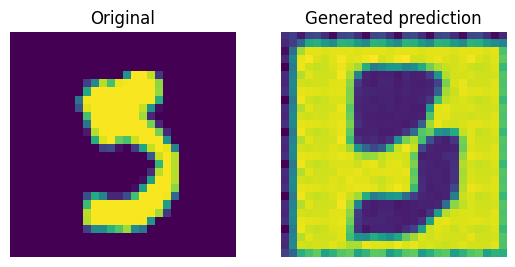

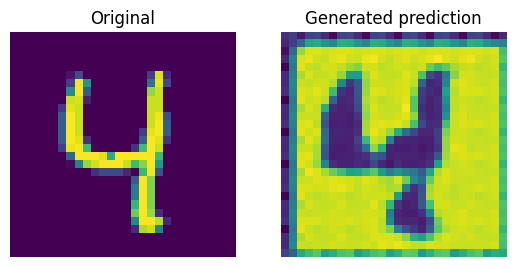

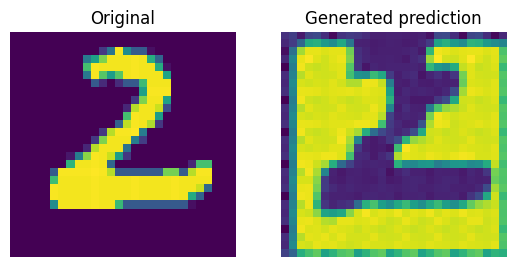

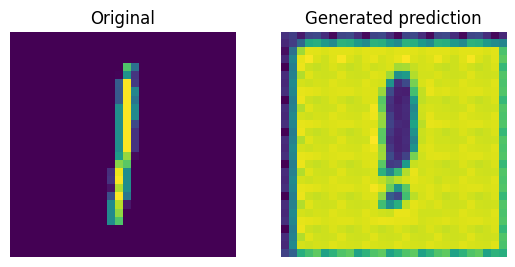

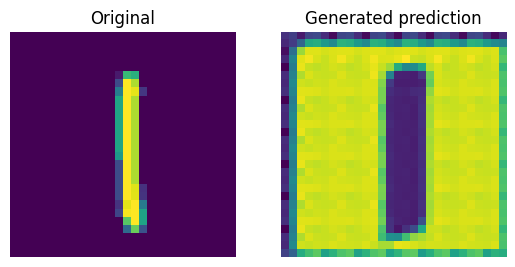

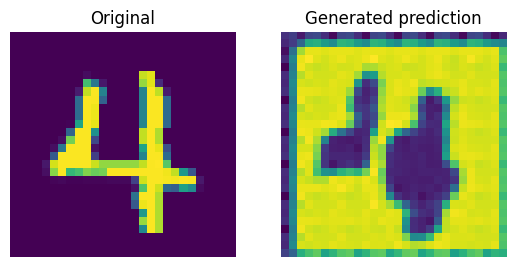

In [ ]:
encoder = vqvae_trainer.vqvae.get_layer("encoder")
quantizer = vqvae_trainer.vqvae.get_layer("vector_quantizer")
decoder = vqvae_trainer.vqvae.get_layer("decoder")
categorical_layer = tfp.layers.DistributionLambda(tfp.distributions.Categorical)

encoded_outputs = encoder.predict(test_images)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs,True)
codebook_indices = categorical_layer(tf.cast(codebook_indices, tf.float32)).sample()
priors_ohe = tf.one_hot(tf.cast(codebook_indices,tf.int32), vqvae_trainer.num_embeddings).numpy()
quantized = tf.matmul(
    priors_ohe, quantizer.embeddings, transpose_b=True
)
quantized = tf.reshape(quantized, (-1, *(encoded_outputs.shape[1:])))

# Generate novel images after categorical sampling.
predicted_img = decoder.predict(quantized)

for i in range(len(test_images)):
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i].squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(predicted_img[i].squeeze()+0.5)
    plt.title("Generated prediction")
    plt.axis("off")
    plt.show()

In [ ]:
categorical_layer = tfp.layers.DistributionLambda(tfp.distributions.Categorical)
rand_array = tf.random.uniform((3,5),0,10)
print(rand_array)
categorical_layer(rand_array).sample()

tf.Tensor(
[[2.634486  7.819351  5.0502644 5.608081  0.8205271]
 [7.168947  7.747284  5.081793  1.7349029 7.8403068]
 [9.863855  9.500916  3.4759843 3.7077892 0.017488 ]], shape=(3, 5), dtype=float32)


<tf.Tensor: shape=(3,), dtype=int32, numpy=array([1, 1, 0], dtype=int32)>

## PixelCNN hyperparameters

In [ ]:
num_residual_blocks = 2
num_pixelcnn_layers = 2
pixelcnn_input_shape = encoded_outputs.shape[1:-1]
print(f"Input shape of the PixelCNN: {pixelcnn_input_shape}")

Input shape of the PixelCNN: (7, 7)


## PixelCNN model

Majority of this comes from
[this example](https://keras.io/examples/generative/pixelcnn/).

## Notes
Thanks to [Rein van 't Veer](https://github.com/reinvantveer) for improving this example with
copy-edits and minor code clean-ups.

In [ ]:
# The first layer is the PixelCNN layer. This layer simply
# builds on the 2D convolutional layer, but includes masking.
class PixelConvLayer(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super().__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)


# Next, we build our residual block layer.
# This is just a normal residual block, but based on the PixelConvLayer.
class ResidualBlock(keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )
        self.pixel_conv = PixelConvLayer(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return keras.layers.add([inputs, x])


pixelcnn_inputs = keras.Input(shape=pixelcnn_input_shape, dtype=tf.int32)
ohe = tf.one_hot(pixelcnn_inputs, vqvae_trainer.num_embeddings)
x = PixelConvLayer(
    mask_type="A", filters=128, kernel_size=7, activation="relu", padding="same"
)(ohe)

for _ in range(num_residual_blocks):
    x = ResidualBlock(filters=128)(x)

for _ in range(num_pixelcnn_layers):
    x = PixelConvLayer(
        mask_type="B",
        filters=128,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = keras.layers.Conv2D(
    filters=vqvae_trainer.num_embeddings, kernel_size=1, strides=1, padding="valid"
)(x)

pixel_cnn = keras.Model(pixelcnn_inputs, out, name="pixel_cnn")
pixel_cnn.summary()

Model: "pixel_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 7, 7)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, 7, 7, 128)         0         
                                                                 
 pixel_conv_layer (PixelConv  (None, 7, 7, 128)        802944    
 Layer)                                                          
                                                                 
 residual_block (ResidualBlo  (None, 7, 7, 128)        98624     
 ck)                                                             
                                                                 
 residual_block_1 (ResidualB  (None, 7, 7, 128)        98624     
 lock)                                                           
                                                         

In [ ]:
# Generate the codebook indices.
encoded_outputs = encoder.predict(x_train_scaled)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)

codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])
print(f"Shape of the training data for PixelCNN: {codebook_indices.shape}")

1875/1875 [==============================] - 3s 2ms/step
Shape of the training data for PixelCNN: (60000, 7, 7)


## PixelCNN training

In [ ]:
pixel_cnn.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
pixel_cnn.fit(
    x=codebook_indices,
    y=codebook_indices,
    batch_size=128,
    epochs=30,
    validation_split=0.1,
)

Epoch 1/30
422/422 [==============================] - 9s 11ms/step - loss: 1.9753 - accuracy: 0.5492 - val_loss: 1.4011 - val_accuracy: 0.5972
Epoch 2/30
422/422 [==============================] - 4s 11ms/step - loss: 1.3082 - accuracy: 0.6120 - val_loss: 1.2673 - val_accuracy: 0.6190
Epoch 3/30
422/422 [==============================] - 5s 12ms/step - loss: 1.2317 - accuracy: 0.6248 - val_loss: 1.2248 - val_accuracy: 0.6263
Epoch 4/30
422/422 [==============================] - 7s 15ms/step - loss: 1.1943 - accuracy: 0.6314 - val_loss: 1.1934 - val_accuracy: 0.6318
Epoch 5/30
422/422 [==============================] - 5s 12ms/step - loss: 1.1677 - accuracy: 0.6363 - val_loss: 1.1795 - val_accuracy: 0.6335
Epoch 6/30
422/422 [==============================] - 4s 10ms/step - loss: 1.1480 - accuracy: 0.6398 - val_loss: 1.1654 - val_accuracy: 0.6357
Epoch 7/30
422/422 [==============================] - 4s 11ms/step - loss: 1.1317 - accuracy: 0.6431 - val_loss: 1.1531 - val_accuracy: 0.6390

We can improve these scores with more training and hyperparameter tuning.

## Codebook sampling

Now that our PixelCNN is trained, we can sample distinct codes from its outputs and pass
them to our decoder to generate novel images.

We now construct a prior to generate images. Here, we will generate 10 images.

In [ ]:
isCatergorical = True
# Create a mini sampler model.
inputs = layers.Input(shape=pixel_cnn.input_shape[1:])
outputs = pixel_cnn(inputs, training=False)
if isCatergorical:
  categorical_layer = tfp.layers.DistributionLambda(tfp.distributions.Categorical)
  outputs = categorical_layer(outputs)
sampler = keras.Model(inputs, outputs)

# Create an empty array of priors.
idx = 1 #np.random.choice(codebook_indices.shape[0])
print(f'conditioned on latent id: {idx}')
batch = 10
# priors = np.random.rand(batch,7,7)
priors = np.zeros(shape=(batch,) + (pixel_cnn.input_shape)[1:])
priors[:]=codebook_indices[idx]
batch, rows, cols = priors.shape

# Iterate over the priors because generation has to be done sequentially pixel by pixel.
for row in range(rows):
    for col in range(cols):
        # Feed the whole array and retrieving the pixel value probabilities for the next
        # pixel.
        probs = sampler.predict(priors)
        # Use the probabilities to pick pixel values and append the values to the priors.
        if isCatergorical:
          priors[:, row, col] = probs[:, row, col]
        else:
          priors[:, row, col] = np.argmax(probs[:, row, col],-1)

print(f"Prior shape: {priors.shape}")

conditioned on latent id: 1
1/1 [==============================] - 0s 41ms/step
Prior shape: (10, 7, 7)


In [ ]:
sampler.pixel_cnn

AttributeError: ignored

We can now use our decoder to generate the images.

1/1 [==============================] - 0s 18ms/step


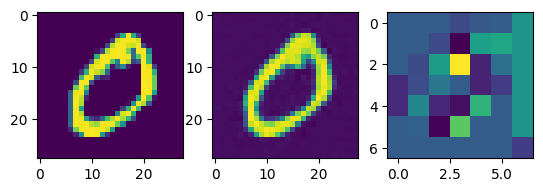

0.17549425884866893


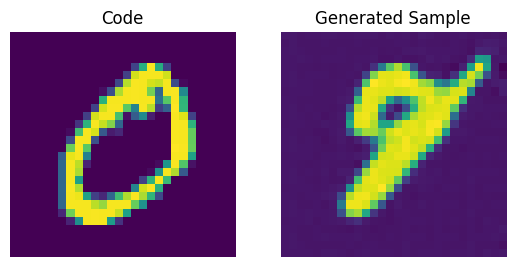

0.19135018525954395


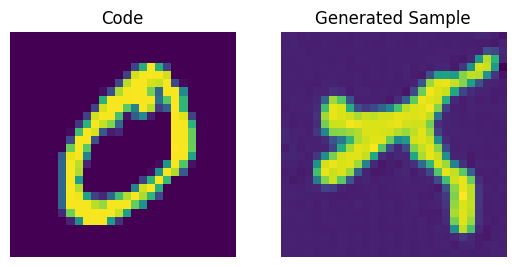

0.09305182466368121


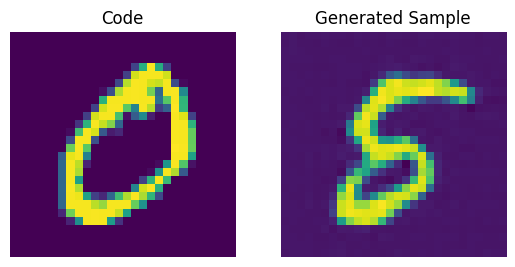

0.19182161435373604


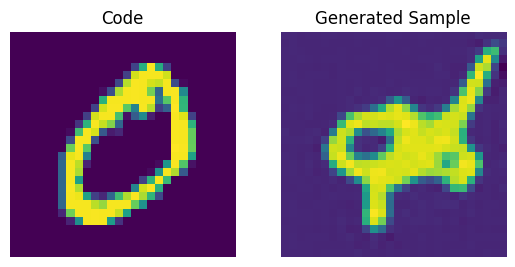

0.14119128931850478


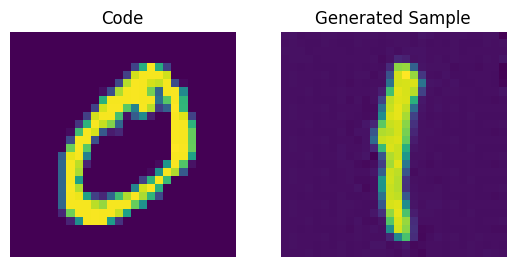

0.19492816022734644


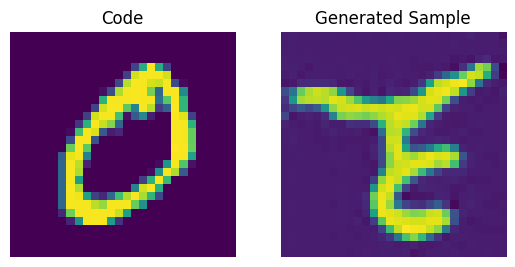

0.17907022154268393


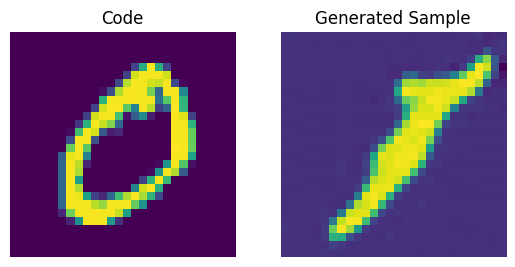

0.1119165435608703


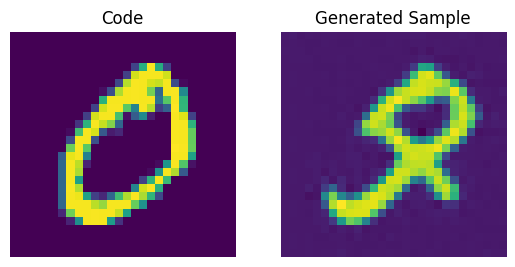

0.15027576737221265


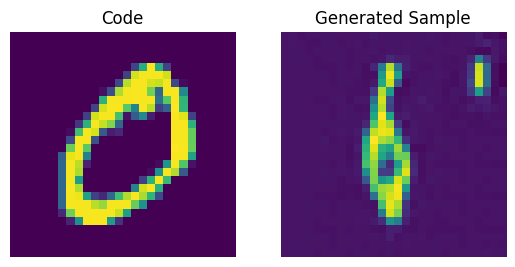

0.14989121132654443


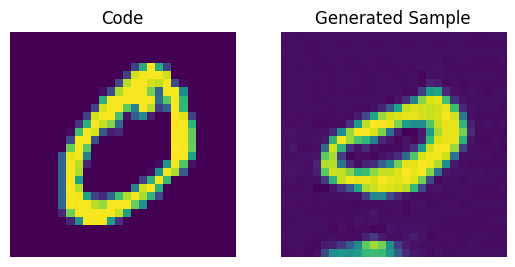

In [ ]:
# Perform an embedding lookup.
pretrained_embeddings = quantizer.embeddings
priors_ohe = tf.one_hot(priors.astype("int32"), vqvae_trainer.num_embeddings).numpy()
quantized = tf.matmul(
    priors_ohe.astype("float32"), pretrained_embeddings, transpose_b=True
)
quantized = tf.reshape(quantized, (-1, *(encoded_outputs.shape[1:])))

# Generate novel images.
decoder = vqvae_trainer.vqvae.get_layer("decoder")
generated_samples = decoder.predict(quantized)

plt.subplot(1,3,1)
plt.imshow(x_train_scaled[idx])
reconstructions_test = trained_vqvae_model.predict(np.expand_dims(x_train_scaled[idx],0))
plt.subplot(1,3,2)
plt.imshow(reconstructions_test[0])
plt.subplot(1,3,3)
plt.imshow(codebook_indices[idx])
plt.show()

for i in range(batch):

    print(((x_train_scaled[idx] - generated_samples[i])**2).mean())
    plt.subplot(1, 2, 1)
    #plt.imshow(priors[i])
    plt.imshow(x_train_scaled[idx])
    plt.title("Code")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(generated_samples[i].squeeze() + 0.5)
    plt.title("Generated Sample")
    plt.axis("off")
    plt.show()

1/1 [==============================] - 0s 19ms/step


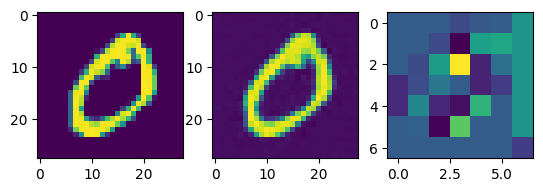

0.11721779224903371


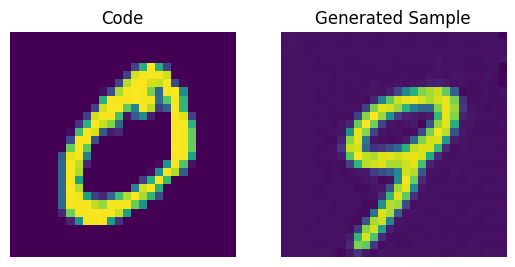

0.11721779195261617


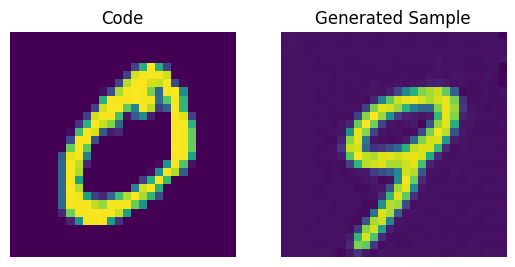

0.11721779252728418


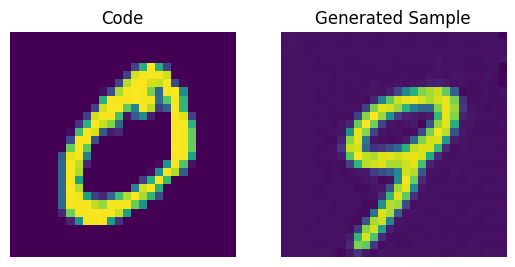

0.11721779269315297


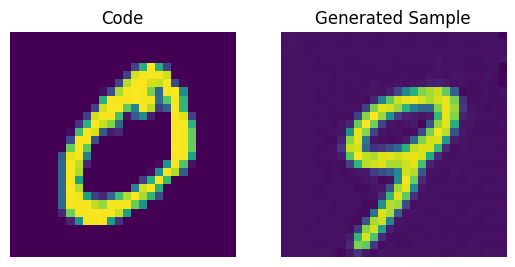

0.1172177909522275


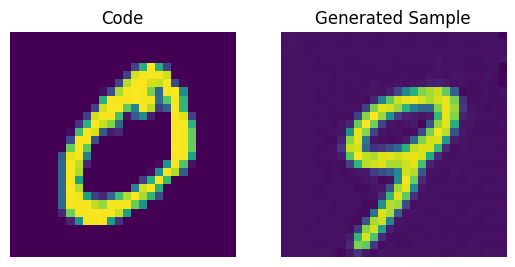

0.1172177924006739


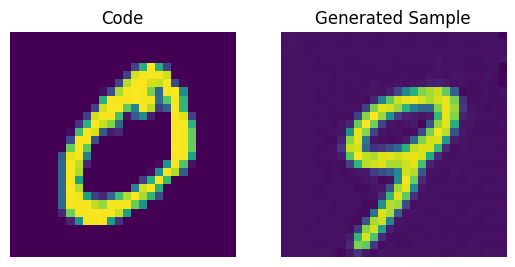

0.11721779239546654


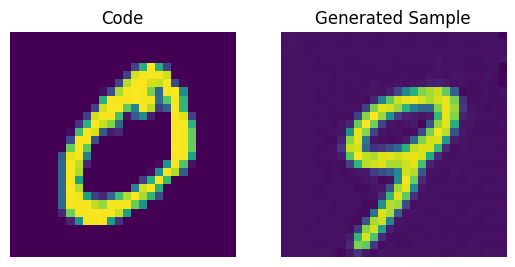

0.11721779159902875


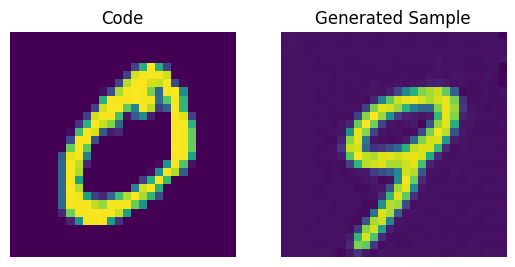

0.11721779167278888


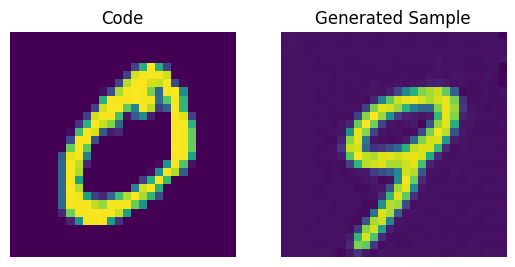

0.11721779188321882


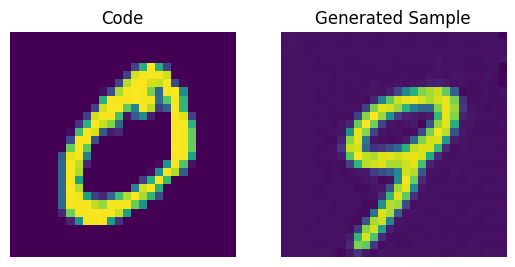

In [ ]:
#Perform an embedding lookup.
#Without categorical distribution sampling layer
pretrained_embeddings = quantizer.embeddings
priors_ohe = tf.one_hot(priors.astype("int32"), vqvae_trainer.num_embeddings).numpy()
quantized = tf.matmul(
    priors_ohe.astype("float32"), pretrained_embeddings, transpose_b=True
)
quantized = tf.reshape(quantized, (-1, *(encoded_outputs.shape[1:])))

# Generate novel images.
decoder = vqvae_trainer.vqvae.get_layer("decoder")
generated_samples = decoder.predict(quantized)

plt.subplot(1,3,1)
plt.imshow(x_train_scaled[idx])
reconstructions_test = trained_vqvae_model.predict(np.expand_dims(x_train_scaled[idx],0))
plt.subplot(1,3,2)
plt.imshow(reconstructions_test[0])
plt.subplot(1,3,3)
plt.imshow(codebook_indices[idx])
plt.show()
for i in range(batch):
    print(((x_train_scaled[idx] - generated_samples[i])**2).mean())
    plt.subplot(1, 2, 1)
    #plt.imshow(priors[i])
    plt.imshow(x_train_scaled[idx])
    plt.title("Code")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(generated_samples[i].squeeze() + 0.5)
    plt.title("Generated Sample")
    plt.axis("off")
    plt.show()

We can enhance the quality of these generated samples by tweaking the PixelCNN.

## Additional notes

* After the VQ-VAE paper was initially released, the authors developed an exponential
moving averaging scheme to update the embeddings inside the quantizer. If you're
interested you can check out
[this snippet](https://github.com/deepmind/sonnet/blob/master/sonnet/python/modules/nets/vqvae.py#L124).
* To further enhance the quality of the generated samples,
[VQ-VAE-2](https://arxiv.org/abs/1906.00446) was proposed that follows a cascaded
approach to learn the codebook and to generate the images.